In [1]:
# Importing modules
import numpy as np
import pandas as pd
import numba
import pyarrow.dataset as ds
import matplotlib.pylab as plt
from tqdm.notebook import tqdm
from astropy.io import fits
from astropy.table import Table
from sklearn import metrics
from astropy.coordinates import SkyCoord
import astropy.units as u

In [2]:
# Pandas display options (personal preference)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

In [3]:
# Matplotlib options
plt.rcParams['xtick.top'] = 'True'
plt.rcParams['ytick.right'] = 'True'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['xtick.minor.visible'] = 'True'
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.minor.visible'] = 'True'
plt.rcParams['axes.linewidth'] = 1.2

plt.rcParams['figure.figsize'] = [10,8]
font = {'size'   : 20}
plt.rc('font', **font)

In [5]:
# Importing the G09 parquet file
dataset = ds.dataset("../data/WD01_2p4.parquet", format="parquet")
table = dataset.to_table()

# Setting uberID as index
df = table.to_pandas().set_index('uberID')
df.index=df.index.astype('int64')

del dataset,table

In [6]:
# Getting rid of weird spaces in the class column
df=df.replace({'class': {'ambiguous ': 'ambiguous',
                         'star      ': 'star', 
                         'galaxy    ': 'galaxy', 
                         'artefact  ':'artefact'}})

In [7]:
# Making a number of cuts: magnitude, mask, starmask and removing artefacts
df=df[(df['mag_Zt']<22) & 
      (df['mask']==0) & 
      (df['starmask']==0) & 
      (df['class']!='artefact')]

In [8]:
# Getting a 1/10 subset of the data (for the purpose of this tutorial)
df=df[::10]

In [9]:
# Reading labels from Notebook 3
df_labels=pd.read_csv('../data/WD01_UMAP_reduced_columns.csv').set_index('uberID')

In [10]:
# Taking the labels and missing bands column into our dataframe
df['missing_bands']=df_labels['missing_bands']
df['final_label']=df_labels['final_label']

In [11]:
# Renaming label columns
df=df.rename(columns={"final_label": "cluster_label"})

In [12]:
# For this analysis, we're just going to look at sources without bands missing
df=df[df['missing_bands']==False]

In [13]:
# Deleting redundant dataframe for RAM
del df_labels

In [14]:
# Define the bands and their corresponding flux columns
bands = ['g', 'r', 'i', 'Z', 'Y', 'J', 'H', 'K']
tot_suffix = 't'
col_suffix = 'c'

# Loop through each band and calculate magnitudes for both 'tot' and 'col'
for band in bands:
    df[f'mag_{band}_tot'] = 8.9 - 2.5 * np.log10(df[f'flux_{band}t'])
    df[f'mag_{band}_col'] = 8.9 - 2.5 * np.log10(df[f'flux_{band}c'])

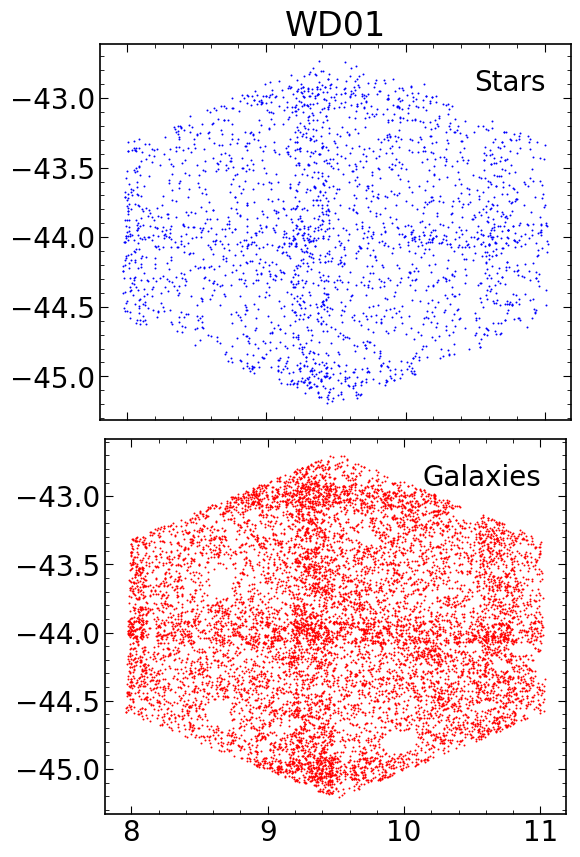

In [16]:
# Plot RA and Dec of stars and galaxies
fig, axs = plt.subplots(2, 1, sharex=True,figsize=(18,10))
fig.subplots_adjust(hspace=0.05)

axs[0].scatter(df[((df['cluster_label']=='star')|(df['cluster_label']=='ambiguous'))]['RAmax'],
            df[((df['cluster_label']=='star')|(df['cluster_label']=='ambiguous')) ]['Decmax'],
                   linewidth=0,s=2,c='blue',label='Stars')
axs[0].set_aspect('equal', adjustable='box')
axs[0].legend(loc='upper right',frameon=False,labelcolor='k')
axs[0].set_title('WD01')


axs[1].scatter(df[(df['cluster_label']=='galaxy') ]['RAmax'],
            df[(df['cluster_label']=='galaxy') ]['Decmax'],
                   linewidth=0,s=2,c='red',label='Galaxies')
axs[1].set_aspect('equal', adjustable='box')
axs[1].legend(loc='upper right',frameon=False,labelcolor='k')

plt.savefig('plots/WD01_UMAP_RA_Dec.jpg',bbox_inches='tight',dpi=100,facecolor='white')


plt.show()

In [17]:
# This is for plotting the baseline method
r_mag_bins_1000=np.linspace(9,25,1000)

def jk_criteria(r):
    if r<19.5:
        return 0.025
    if r>19.5:
        return 0.025 + 0.025*(r - 19.5)
    
def jk_criteria2(r):
    if r<19.5:
        return 0.025
    if r>19.5:
        return 0.025 - 0.1*(r - 19.5)**2
    
seeing=np.median(df['log10seeing'])

def rad_criteria(r):
    return seeing + 0.05 - 0.075*(r-20.5)

def rad_criteria_2(r):
    if r>20.5:
        return seeing + 0.05

AttributeError: 'Legend' object has no attribute 'legendHandles'

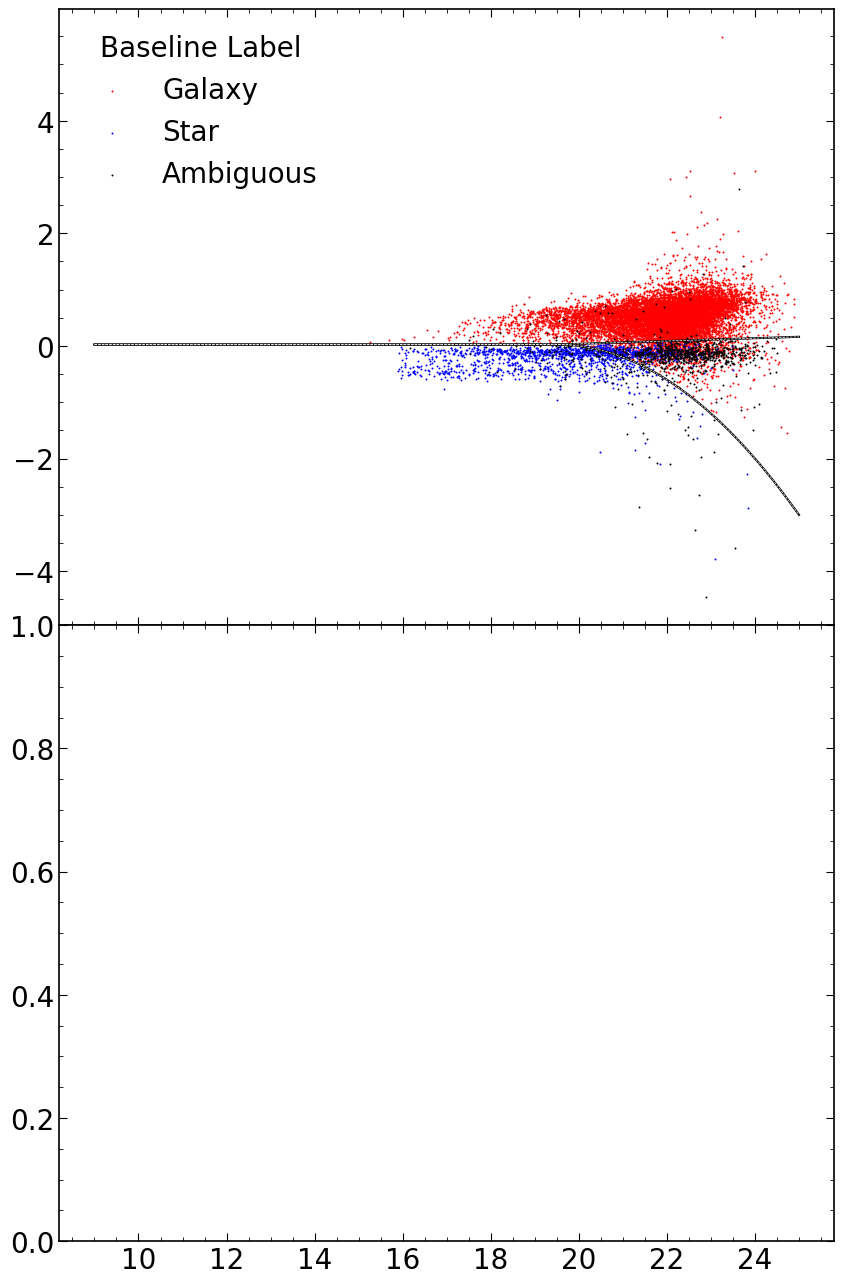

In [18]:
# Baseline method plot
fig, axs = plt.subplots(2, 1, sharex=True,figsize=(10,16))
fig.subplots_adjust(hspace=0)

axs[0].scatter(df[df['class']=='galaxy']['mag_r_tot'],
            df[df['class']=='galaxy']['mag_J_tot']-df[df['class']=='galaxy']['mag_K_tot'],
            color='red',linewidth=0,s=2,label='Galaxy')
axs[0].scatter(df[df['class']=='star']['mag_r_tot'],
            df[df['class']=='star']['mag_J_tot']-df[df['class']=='star']['mag_K_tot'],
            color='blue',linewidth=0,s=2,label='Star')
axs[0].scatter(df[df['class']=='ambiguous']['mag_r_tot'],
            df[df['class']=='ambiguous']['mag_J_tot']-df[df['class']=='ambiguous']['mag_K_tot'],
            color='k',linewidth=0,s=2,label='Ambiguous')

axs[0].plot(r_mag_bins_1000,list(map(jk_criteria, r_mag_bins_1000)),c='k')
axs[0].plot(r_mag_bins_1000,list(map(jk_criteria2, r_mag_bins_1000)),c='k')

axs[0].plot(r_mag_bins_1000,list(map(jk_criteria, r_mag_bins_1000)),
                                 c='white',linestyle='dashed',linewidth=0.5)
axs[0].plot(r_mag_bins_1000,list(map(jk_criteria2, r_mag_bins_1000)),
                                 c='white',linestyle='dashed',linewidth=0.5)

lgnd=axs[0].legend(frameon=False,loc='upper left',title='Baseline Label')

lgnd.legendHandles[0]._sizes = [100]
lgnd.legendHandles[1]._sizes = [100]
lgnd.legendHandles[2]._sizes = [100]

axs[0].set_xlim(13,25)
axs[0].set_ylim(-1,2)
axs[0].set_ylabel('J-Ks colour')


axs[1].scatter(df[df['class']=='galaxy']['mag_r_tot'],
            np.log10(df[df['class']=='galaxy']['R50']),color='red',linewidth=0,s=2)
axs[1].scatter(df[df['class']=='star']['mag_r_tot'],
            np.log10(df[df['class']=='star']['R50']),color='blue',linewidth=0,s=2)
axs[1].scatter(df[df['class']=='ambiguous']['mag_r_tot'],
            np.log10(df[df['class']=='ambiguous']['R50']),color='k',linewidth=0,s=2)

axs[1].plot(r_mag_bins_1000,list(map(rad_criteria, r_mag_bins_1000)),c='k')
axs[1].plot(r_mag_bins_1000,list(map(rad_criteria_2, r_mag_bins_1000)),c='k')

axs[1].plot(r_mag_bins_1000,list(map(rad_criteria, r_mag_bins_1000)),
         c='white',linestyle='dashed',linewidth=0.5)
axs[1].plot(r_mag_bins_1000,list(map(rad_criteria_2, r_mag_bins_1000)),
         c='white',linestyle='dashed',linewidth=0.5)

axs[1].set_xlim(13,25)
axs[1].set_ylim(-0.42,0.5)

axs[1].set_xlabel('r-band magnitude')
axs[1].set_ylabel('log(R50/arcsec)')

plt.savefig('plots/WD01_baseline_classification.jpg',bbox_inches='tight',dpi=100,facecolor='white')


plt.show()

/var/folders/yh/x5pbtyx970b2p_4xnnncyq800000gn/T/ipykernel_28714/4050667374.py:22: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd.legendHandles[0]._sizes = [100]
/var/folders/yh/x5pbtyx970b2p_4xnnncyq800000gn/T/ipykernel_28714/4050667374.py:23: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd.legendHandles[1]._sizes = [100]


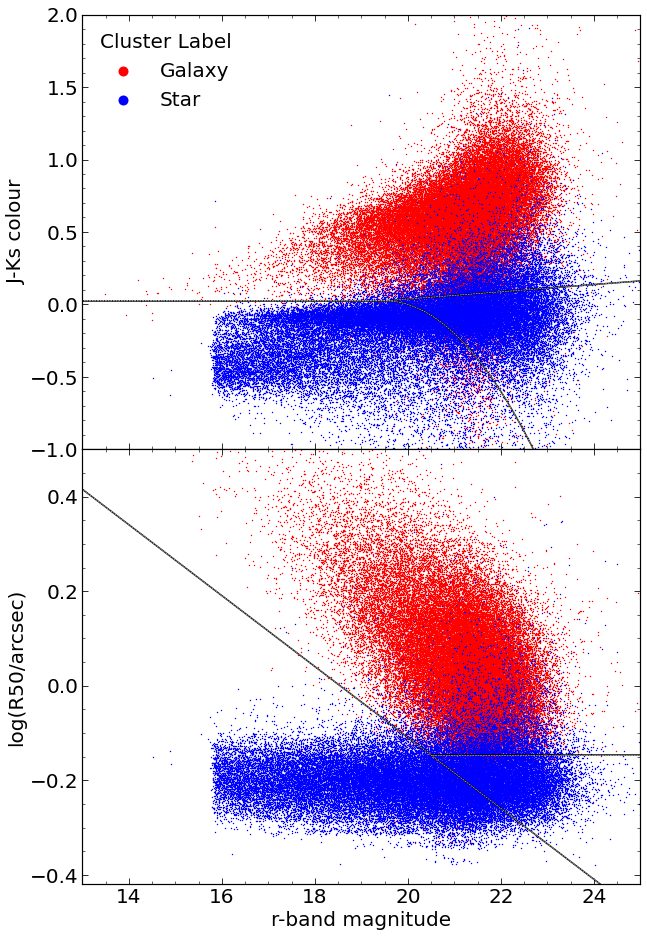

In [20]:
# Plotting the same but our new cluster labels
fig, axs = plt.subplots(2, 1, sharex=True,figsize=(10,16))
fig.subplots_adjust(hspace=0)

axs[0].scatter(df[df['cluster_label']=='galaxy']['mag_r_tot'],
            df[df['cluster_label']=='galaxy']['mag_J_tot']-df[df['cluster_label']=='galaxy']['mag_K_tot'],
            color='red',linewidth=0,s=2,label='Galaxy')
axs[0].scatter(df[df['cluster_label']=='star']['mag_r_tot'],
            df[df['cluster_label']=='star']['mag_J_tot']-df[df['cluster_label']=='star']['mag_K_tot'],
            color='blue',linewidth=0,s=2,label='Star')

axs[0].plot(r_mag_bins_1000,list(map(jk_criteria, r_mag_bins_1000)),c='k')
axs[0].plot(r_mag_bins_1000,list(map(jk_criteria2, r_mag_bins_1000)),c='k')

axs[0].plot(r_mag_bins_1000,list(map(jk_criteria, r_mag_bins_1000)),
                                 c='white',linestyle='dashed',linewidth=0.5)
axs[0].plot(r_mag_bins_1000,list(map(jk_criteria2, r_mag_bins_1000)),
                                 c='white',linestyle='dashed',linewidth=0.5)

lgnd=axs[0].legend(frameon=False,loc='upper left',title='Cluster Label')

lgnd.legendHandles[0]._sizes = [100]
lgnd.legendHandles[1]._sizes = [100]

axs[0].set_xlim(13,25)
axs[0].set_ylim(-1,2)

axs[0].set_ylabel('J-Ks colour')


axs[1].scatter(df[df['cluster_label']=='galaxy']['mag_r_tot'],
            np.log10(df[df['cluster_label']=='galaxy']['R50']),color='red',linewidth=0,s=2)
axs[1].scatter(df[df['cluster_label']=='star']['mag_r_tot'],
            np.log10(df[df['cluster_label']=='star']['R50']),color='blue',linewidth=0,s=2)

axs[1].plot(r_mag_bins_1000,list(map(rad_criteria, r_mag_bins_1000)),c='k')
axs[1].plot(r_mag_bins_1000,list(map(rad_criteria_2, r_mag_bins_1000)),c='k')

axs[1].plot(r_mag_bins_1000,list(map(rad_criteria, r_mag_bins_1000)),
         c='white',linestyle='dashed',linewidth=0.5)
axs[1].plot(r_mag_bins_1000,list(map(rad_criteria_2, r_mag_bins_1000)),
         c='white',linestyle='dashed',linewidth=0.5)

axs[1].set_xlim(13,25)
axs[1].set_ylim(-0.42,0.5)

axs[1].set_xlabel('r-band magnitude')
axs[1].set_ylabel('log(R50/arcsec)')


plt.show()

In [19]:
# Importing GAMA data for use as ground truth
hdul = fits.open('../data/gkvScienceCatv02.fits')
data = hdul[1].data
cols = hdul[1].columns
t=Table(data)
df_gama=t.to_pandas().set_index('uberID')

In [20]:
# Removing duplicates, sources within starmask and filtering by sources with good redshift
df_gama=df_gama[df_gama['duplicate']==False]
df_gama=df_gama[df_gama['starmask']==False]
df_gama=df_gama[df_gama['NQ']>2]

In [21]:
# Cross matching by 0.6 arcsec
max_sep=0.6*u.arcsec
waves = SkyCoord(ra=df['RAmax'].values*u.degree, dec=df['Decmax'].values*u.degree)
gama = SkyCoord(ra=df_gama['RAmax'].values*u.degree, dec=df_gama['Decmax'].values*u.degree)
idx, d2d, d3d = waves.match_to_catalog_sky(gama)
sep_constraint = d2d < max_sep

# waves_matches will the dataframe that contains the crossmatches, but retains the information from the G09 catalogue
waves_matches=df.iloc[sep_constraint]
gama_matches=df_gama.iloc[idx[sep_constraint]]
len(gama_matches)

0

In [22]:
# Transferring the information (classification, NQ and redshift) to crossmatch dataframe
waves_matches['spec_class']=gama_matches['uberclass'].values
waves_matches['NQ']=gama_matches['NQ'].values
waves_matches['Z']=gama_matches['Z'].values

In [23]:
# Converting the GAMA spec class from numbers to galaxy/star/ambiguous
waves_matches['spec_class']=waves_matches['spec_class'].replace([1], 'galaxy')
waves_matches['spec_class']=waves_matches['spec_class'].replace([2], 'star')
waves_matches['spec_class']=waves_matches['spec_class'].replace([3], 'ambiguous')

/tmp/ipykernel_221276/2232546459.py:9: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  im = ax.imshow(data_percentage / 100, vmin=0, vmax=1, cmap='Blues')
/tmp/ipykernel_221276/2232546459.py:9: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  im = ax.imshow(data_percentage / 100, vmin=0, vmax=1, cmap='Blues')


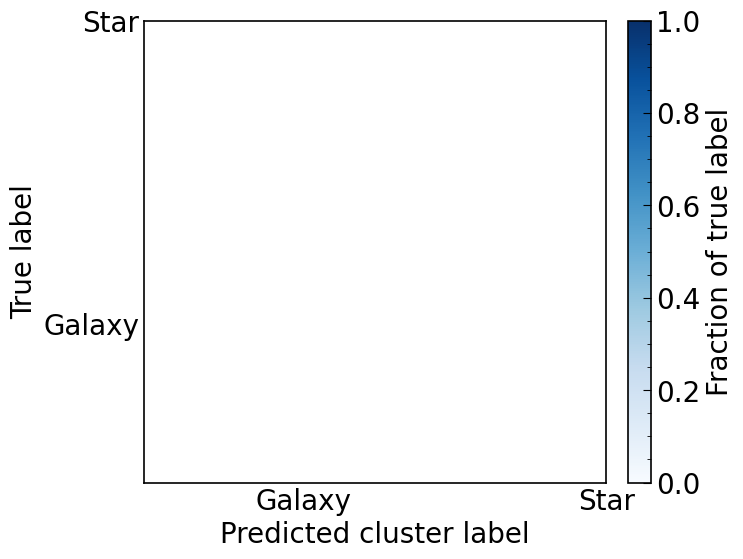

In [24]:
# Creating a confusion matrix for GAMA labels and our cluster labels
data = metrics.confusion_matrix(waves_matches['spec_class'], waves_matches['cluster_label'])[1:3,1:3]

# Calculate percentage
data_percentage = data / np.sum(data, axis=1)[:, None] * 100

# Plotting
fig, ax = plt.subplots(figsize=(7, 6))
im = ax.imshow(data_percentage / 100, vmin=0, vmax=1, cmap='Blues')

# Labels
x_label_list = ['Galaxy', 'Star']
y_label_list = ['Galaxy', 'Star']

# Text annotations, should be black if <50% and white if >50%
for i in range(data.shape[1]):
    for j in range(data.shape[0]):
        c = data[j, i]
        color = 'white' if c > np.sum(data[j]) / 2 else 'black'
        ax.text(i, j - 0.05, f'{c}', va='center', ha='center', color=color)
        c_percentage = round(data_percentage[j, i], 2)
        ax.text(i, j + 0.05, f'({c_percentage}%)', va='center', ha='center', color=color)

cbar = fig.colorbar(im, label='Fraction of true label', fraction=0.045, pad=0.04)

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)

ax.set_xlabel('Predicted cluster label')
ax.set_ylabel('True label')

plt.savefig('plots/WD01_cluster_confusion.jpg',bbox_inches='tight',dpi=100,facecolor='white')

plt.show()

/tmp/ipykernel_221276/647699795.py:9: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  im = ax.imshow(data_percentage / 100, vmin=0, vmax=1, cmap='Blues')
/tmp/ipykernel_221276/647699795.py:9: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  im = ax.imshow(data_percentage / 100, vmin=0, vmax=1, cmap='Blues')


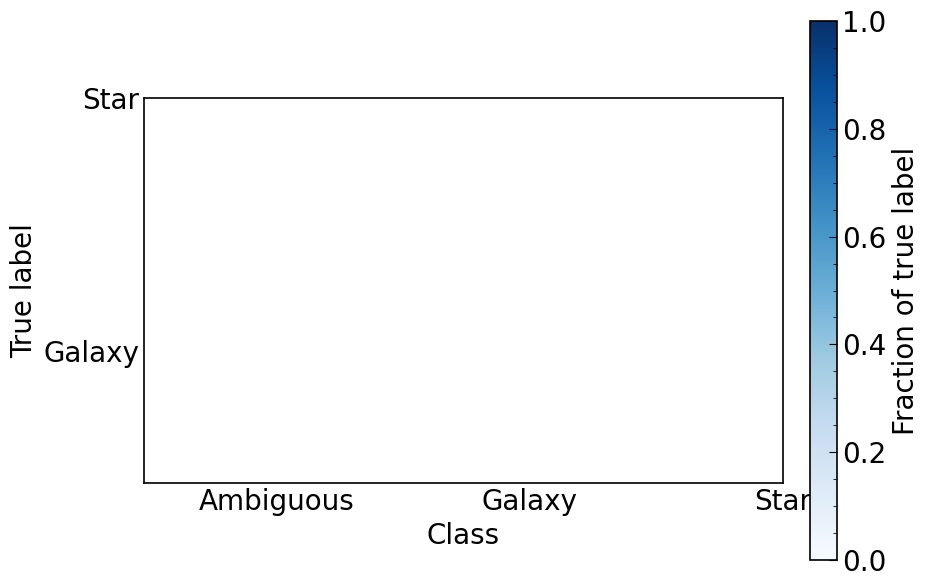

In [25]:
# Doing the same but for the baseline classifictions
data = metrics.confusion_matrix(waves_matches['spec_class'], waves_matches['class'])[1:3]

# Calculate percentage
data_percentage = data / np.sum(data, axis=1)[:, None] * 100

# Plotting
fig, ax = plt.subplots(figsize=(9,7))
im = ax.imshow(data_percentage / 100, vmin=0, vmax=1, cmap='Blues')

# Labels
x_label_list = ['Ambiguous','Galaxy', 'Star']
y_label_list = ['Galaxy', 'Star']

# Text annotations, should be black if <50% and white if >50%
for i in range(data.shape[1]):
    for j in range(data.shape[0]):
        c = data[j, i]
        color = 'white' if c > np.sum(data[j]) / 2 else 'black'
        ax.text(i, j - 0.05, f'{c}', va='center', ha='center', color=color)
        c_percentage = round(data_percentage[j, i], 2)
        ax.text(i, j + 0.05, f'({c_percentage}%)', va='center', ha='center', color=color)

cbar = fig.colorbar(im, label='Fraction of true label', fraction=0.045, pad=0.04)

ax.set_xticks([0, 1,2])
ax.set_yticks([0, 1])
ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)

ax.set_xlabel('Class')
ax.set_ylabel('True label')

plt.savefig('plots/WD01_baseline_confusion.jpg',bbox_inches='tight',dpi=100,facecolor='white')

plt.show()